In [ ]:
!unzip -qq sign.zip

In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import torchvision.transforms as transforms
from torchvision import datasets,models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings
import copy
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import wandb

In [ ]:
warnings.filterwarnings("ignore")

## Configuration of the folders

In [ ]:
Home= Path().resolve().as_posix()

In [ ]:

os.mkdir(Home+"/Training")
os.mkdir(Home+"/Validation")
os.mkdir(Home+"/Testing")

In [ ]:
Priority_Length=len(os.listdir(Home+"/sign/Priority"))
Stop_Length=len(os.listdir(Home+"/sign/Stop"))
total_length=Priority_Length+Stop_Length

In [ ]:
df_Priority=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(Priority_Length)])
df_Priority["image_path"]=os.listdir(Home+"/sign/Priority")
df_Priority["label"]="Priority"

df_Stop=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(Stop_Length)])
df_Stop["image_path"]=os.listdir(Home+"/sign/Stop")
df_Stop["label"]="Stop"

## Data Spiltting

In [ ]:
x_priority=df_Priority.image_path
y_priority=df_Priority.label
X_train_priority,X_test_priority,y_train_priority,y_test_priority=train_test_split(x_priority,y_priority,test_size=0.30,random_state=42)
X_train_priority,X_valid_priority,y_train_priority,y_valid_priority=train_test_split(X_train_priority,y_train_priority,test_size=0.20,random_state=42)

In [ ]:
x_Stop=df_Stop.image_path
y_Stop=df_Stop.label
X_train_Stop,X_test_Stop,y_train_Stop,y_test_Stop=train_test_split(x_Stop,y_Stop,test_size=0.30,random_state=42)
## change to 30 percent
X_train_Stop,X_valid_Stop,y_train_Stop,y_valid_Stop=train_test_split(X_train_Stop,y_train_Stop,test_size=0.20,random_state=42)

In [ ]:
X_train=list(X_train_priority)+list(X_train_Stop)
y_train=list(y_train_priority)+list(y_train_Stop)
###############################
X_valid=list(X_valid_priority)+list(X_valid_Stop)
y_valid=list(y_valid_priority)+list(y_valid_Stop)
###############################
X_test=list(X_test_priority)+list(X_test_Stop)
y_test=list(y_test_priority)+list(y_test_Stop)

In [ ]:
df_training=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_train))])
df_training["image_path"]=X_train
df_training["label"]=y_train

df_Validation=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_valid))])
df_Validation["image_path"]=X_valid
df_Validation["label"]=y_valid


df_Test=pd.DataFrame(columns=["image_path","label"],index=[i for i in range(len(X_test))])
df_Test["image_path"]=X_test
df_Test["label"]=y_test

In [ ]:
train_priority=df_training[df_training["label"]=="Priority"]["image_path"].values.tolist()
train_Stop=df_training[df_training["label"]=="Stop"]["image_path"].values.tolist()

valid_priority=df_Validation[df_Validation["label"]=="Priority"]["image_path"].values.tolist()
valid_Stop=df_Validation[df_Validation["label"]=="Stop"]["image_path"].values.tolist()

test_priority=df_Test[df_Test["label"]=="Priority"]["image_path"].values.tolist()
test_Stop=df_Test[df_Test["label"]=="Stop"]["image_path"].values.tolist()

In [ ]:
os.mkdir(Home+"/Training/Priority")
os.mkdir(Home+"/Training/Stop")

os.mkdir(Home+"/Validation/Priority")
os.mkdir(Home+"/Validation/Stop")

os.mkdir(Home+"/Testing/Priority")
os.mkdir(Home+"/Testing/Stop")

In [ ]:
def copy_data(source,destination,path_list):
    for image in path_list:
        image_src_path=source+'/'+image
        image_dest_path=destination+'/'+image
        shutil.copy(image_src_path,image_dest_path)

In [ ]:
# copy the priorrity training data to training priority
source=Home+"/sign/Priority"
destination=Home+"/Training/Priority"
copy_data(source,destination,train_priority)

# copy the priority validation data to validation priority
destination1=Home+"/Validation/Priority"
copy_data(source,destination1,valid_priority)

# copy the priority testing data to testing priority
destination2=Home+"/Testing/Priority"
copy_data(source,destination2,test_priority)

#####################################################################################
# copy the stop training data to training Stop
source1=Home+"/sign/Stop"
destination3=Home+"/Training/Stop"
copy_data(source1,destination3,train_Stop)

# copy the Stop validation data to validation Stop
destination4=Home+"/Validation/Stop"
copy_data(source1,destination4,valid_Stop)

# copy the stop test data to  test stop
destination5=Home+"/Testing/Stop"
copy_data(source1,destination5,test_Stop)


In [ ]:
def load_data(tra_path, val_path):
    transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = datasets.ImageFolder(root=tra_path, transform=transform)
    validset = datasets.ImageFolder(root=val_path, transform=transform) #
    return trainset, validset

In [ ]:
train_path=Home+"/Training"
valid_path=Home+"/Validation"
train_set,valid_set=load_data(train_path,valid_path)

In [ ]:
# Define batch size for data loader
batch_size = 32
# Create data loaders for training and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

In [ ]:
def denormalize(tensor, mean, std):
    tensor = tensor.clone() # Clone tensor to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m) # Unnormalize the image
    return tensor

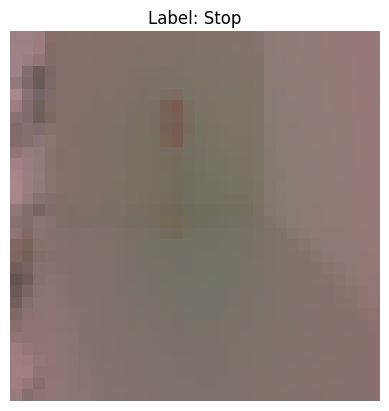

In [ ]:
# Get one batch of images and labels
images, labels = next(iter(train_loader))
# Select one image from the batch
image = images[0]
label = labels[0]
# Denormalize the image
image = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# Convert the image tensor to a NumPy array
image = image.numpy().transpose((1, 2, 0))
# Plot the image
plt.imshow(image)
plt.title(f'Label: {train_set.classes[label]}')
plt.axis('off')
plt.show()

In [ ]:
# Load pre-trained ResNet-18 model and modify it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

cuda


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
layer1.0.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight: torch.Size([64])
layer1.0.bn1.bias: torch.Size([64])
layer1.0.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight: torch.Size([64])
layer1.0.bn2.bias: torch.Size([64])
layer1.1.conv1.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight: torch.Size([64])
layer1.1.bn1.bias: torch.Size([64])
layer1.1.conv2.weight: torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight: torch.Size([64])
layer1.1.bn2.bias: torch.Size([64])
layer2.0.conv1.weight: torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight: torch.Size([128])
layer2.0.bn1.bias: torch.Size([128])
layer2.0.conv2.weight: torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight: torch.Size([128])
layer2.0.bn2.bias: torch.Size([128])
layer2.0.downsample.0.weight: torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight: torch.Size([128])
layer2.0.downsample.1.bias: torch.Size([128])
l

In [ ]:
def train_my_model(num_epoch, model, criterion, optimizer, train_loader, valid_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device
    criterion.to(device)  # Move criterion to the appropriate device

    for epoch in range(num_epoch):
        # Training phase
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Accumulate loss for each batch
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valid_loader)
        val_accuracy = correct / len(valid_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    return model

In [ ]:
model=train_my_model(200,model, criterion, optimizer, train_loader, valid_loader)

Epoch 1, Train Loss: 0.0592, Val Loss: 0.3540, Val Accuracy: 0.8889
Epoch 2, Train Loss: 0.0176, Val Loss: 0.3883, Val Accuracy: 0.8704
Epoch 3, Train Loss: 0.0080, Val Loss: 0.4173, Val Accuracy: 0.8704
Epoch 4, Train Loss: 0.0143, Val Loss: 0.2971, Val Accuracy: 0.8704
Epoch 5, Train Loss: 0.0204, Val Loss: 0.5034, Val Accuracy: 0.8889
Epoch 6, Train Loss: 0.0301, Val Loss: 0.5571, Val Accuracy: 0.9074
Epoch 7, Train Loss: 0.0042, Val Loss: 0.5554, Val Accuracy: 0.9259
Epoch 8, Train Loss: 0.0154, Val Loss: 0.5594, Val Accuracy: 0.9259
Epoch 9, Train Loss: 0.0061, Val Loss: 0.5669, Val Accuracy: 0.9259
Epoch 10, Train Loss: 0.0040, Val Loss: 0.5324, Val Accuracy: 0.9074
Epoch 11, Train Loss: 0.0276, Val Loss: 0.5857, Val Accuracy: 0.9074
Epoch 12, Train Loss: 0.0282, Val Loss: 0.7907, Val Accuracy: 0.9074
Epoch 13, Train Loss: 0.0116, Val Loss: 0.5437, Val Accuracy: 0.8704
Epoch 14, Train Loss: 0.0103, Val Loss: 0.4447, Val Accuracy: 0.8889
Epoch 15, Train Loss: 0.0027, Val Loss: 0.3

## Predition on testing data

In [ ]:
tst_path=Home+"/Testing"

In [ ]:
transform_test = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = datasets.ImageFolder(root=tst_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
predictions = []
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)  # Move images to the appropriate device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().tolist())

In [ ]:
print(predictions)

[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
image_paths = []
# Iterate over the files in the directory and append their paths to the list
for root, dirs, files in os.walk(tst_path):
    for file in files:
        if file.endswith(".jpg"):
            file_path = os.path.join(root, file)
            image_paths.append(file_path)

In [ ]:
len(predictions),len(image_paths)

(114, 114)

In [ ]:
results = pd.DataFrame(columns=['image', 'class','id'])

In [ ]:
results['image'] = image_paths
results['id'] = predictions

In [ ]:
id2label = {0: 'Priority', 1: 'Stop'}
results['class'] = results['id'].apply(lambda x: id2label[x])
results

,image,class,id
0,/content/Testing/Priority/2b14dc8c-0ed5-11ef-8...,Priority,0
1,/content/Testing/Priority/0693a67c-0ed5-11ef-8...,Priority,0
2,/content/Testing/Priority/85d033e2-0ed5-11ef-8...,Priority,0
3,/content/Testing/Priority/2f6414ac-0ed4-11ef-b...,Priority,0
4,/content/Testing/Priority/26bc297a-0ed4-11ef-b...,Priority,0
...,...,...,...
109,/content/Testing/Stop/bf82c854-ed96-11ed-926d-...,Stop,1
110,/content/Testing/Stop/0a27272a-ed96-11ed-926d-...,Stop,1
111,/content/Testing/Stop/55481606-ed96-11ed-926d-...,Stop,1
112,/content/Testing/Stop/cd46f208-ed96-11ed-926d-...,Stop,1


from matplotlib import pyplot as plt
results['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results, x='id', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('class').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['id']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('class')):
  _plot_series(series, series_name, i)
  fig.legend(title='class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('id')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('class')):
  _plot_series(series, series_name, i)
  fig.legend(title='class', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['class'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='id', y='class', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
data_list_Priority=["Priority"]*46
data_list_Stop=["Stop"]*68
Total_data=data_list_Priority+data_list_Stop
results["Goldsatndard"]=Total_data



In [ ]:
accuracy_score(results["Goldsatndard"].values.tolist(), results["class"].values.tolist())

0.9736842105263158

## Save model

In [ ]:
torch.save(model.state_dict(), 'Group6_imageclassfication_modelV0.1.pth')

In [ ]:
os.environ["WANDB_NOTEBOOK_NAME"] = "Imageclassfication.ipynb"

In [ ]:

# Initialize a new W&B run
run = wandb.init(project="Image_Classificationv0")

# Create a new artifact
artifact = wandb.Artifact('model', type='model')

# Add a model file to the artifact
artifact.add_file('Group6_imageclassfication_modelV0.1.pth')

# Log the artifact to W&B
run.log_artifact(artifact)

# Finish the run
run.finish()

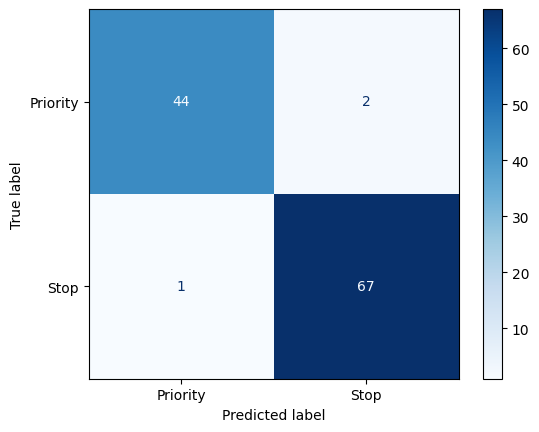

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(results["Goldsatndard"].values.tolist(), results["class"].values.tolist())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results["Goldsatndard"].unique().tolist())
disp.plot(cmap=plt.cm.Blues)
plt.show()